In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import google.generativeai as genai
from gemini_cell_agent.utils import exec_code, streaming_markdown, load_env
from gemini_cell_agent.sys_prompt import pkg_sys_prompt
import PIL.Image
import datetime

load_env('../.env')
#context_file = genai.upload_file(path='../data/cellpose.txt')
#sys_prompt = pkg_sys_prompt('cellpose')

with open('/Users/cat/demo/sysprompt.txt') as f:
    sys_prompt = f.read()

genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model_name = "gemini-1.5-flash"
config = genai.GenerationConfig(temperature=0)

# Create a cache with a 5 minute TTL
# cache = genai.caching.CachedContent.create(
#     model=f'models/{model_name}-001',
#     display_name='cellpose github repo content', # used to identify the cache
#     system_instruction=sys_prompt,
#     contents=[context_file],
#     ttl=datetime.timedelta(minutes=10),
# )

# model = genai.GenerativeModel.from_cached_content(cached_content=cache, generation_config=config)
model = genai.GenerativeModel(model_name, system_instruction=sys_prompt, generation_config=config)

In [3]:
class Chatbot:
    def __init__(self):
        self.chat_history = []

    def chat(self, user_input, img_path=None):
        input_msg = user_input + f'\n\n Remember for coding tasks, please review the correct and wrong coding examples before generating the code.'
        if img_path is not None:
            input_msg = [input_msg + '\n image path:' + img_path, PIL.Image.open(img_path)]
        msg = streaming_markdown(model.start_chat(history=self.chat_history).send_message(input_msg, stream=True))
        if isinstance(input_msg, list):
            input_msg = input_msg[0]
        self.chat_history.append({"role": "user", "parts": input_msg})
        self.chat_history.append({"role": "model", "parts": msg})

        while True:
            if "```python" not in msg:
                break
            res = input("Execute code? (y/n): ")
            if res.lower() == 'y':
                code = msg.split("```python")[1].split("```")[0]
                print('Executing the generated code ...')
                captured_output, error_message = exec_code(code)
                print('Code execution done')
                if error_message:
                    print(f"Error: {error_message}")
                    debug_res = input("Debug the code? (y/n): ")
                    if debug_res.lower() == 'y':
                        debug_input = f"Error: {error_message}\n\nType and shape of the vars in the code:\n{captured_output}\n\nCode:\n{code}"
                        msg = streaming_markdown(model.start_chat(history=self.chat_history).send_message(debug_input, stream=True))
                        self.chat_history.append({"role": "user", "parts": debug_input})
                        self.chat_history.append({"role": "model", "parts": msg})
                    else:
                        print("Ok, I won't debug the code.")
                        break
                else:
                    break
            else:
                print("Ok, I won't execute the code.")
                break

In [4]:
chatbot = Chatbot()

In [5]:
chatbot.chat('What is cellpose?')

Cellpose is an open-source, user-friendly Python package designed for image segmentation.  It excels at identifying and segmenting cells and other objects in microscopy images, even in challenging scenarios with varying cell shapes, sizes, and densities.  Unlike many other segmentation methods, Cellpose doesn't require extensive training data or parameter tuning.  It uses a convolutional neural network (CNN) trained on a large dataset of diverse biological images, making it robust and adaptable to various image types.  Key features include:

- **Robustness:** Handles diverse cell morphologies and image qualities.
- **Ease of use:** Minimal parameter tuning needed; defaults often suffice.
- **Speed:** Relatively fast segmentation, even for large images.
- **Flexibility:** Adaptable to different microscopy techniques and cell types.
- **Denoising capabilities:**  Includes a built-in denoising model to improve image quality before segmentation.


In short, Cellpose provides a powerful and accessible tool for researchers and scientists needing accurate and efficient cell segmentation in their image analysis workflows.


In [6]:
!cp /Users/cat/Downloads/data/general/img0.png ./

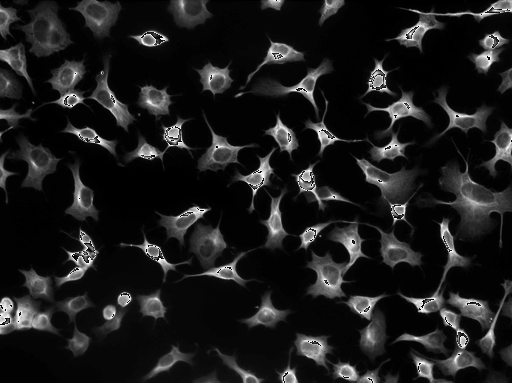

In [7]:
PIL.Image.open('./img0.png')

In [8]:
chatbot.chat('please describe this image', './img0.png')

The image shows a microscopic view of a cell culture.  It appears to be a grayscale image, likely a fluorescence microscopy image, depicting numerous cells with a characteristic elongated or stellate (star-shaped) morphology. The cells are relatively densely packed, and their boundaries are somewhat indistinct, but their overall shapes are clearly visible against a dark background.  The image suggests a type of cell with extensive processes or projections extending from the main cell body.  The brightness variations within the cells might indicate differences in intracellular components or staining intensity.  Without further information, it's impossible to identify the specific cell type.


```python
import numpy as np
from cellpose import models, plot
import matplotlib.pyplot as plt
from skimage.io import imread

# Load the image
img = imread('./img0.png')
if len(img.shape) == 3 and img.shape[-1]<=4:
    img = img[:,:,:3]
diameter = 30  # Adjust if needed based on cell size

# Instantiate the Cellpose model (using CPU)
model = models.Cellpose(gpu=False, model_type='cyto')

# Run cellpose to get masks and flows
masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=[0, 0])

# Display the segmentation results
fig = plt.figure(figsize=(12, 5))
plot.show_segmentation(fig, img, masks, flows[0], channels=[0, 0])
plt.tight_layout()
plt.show()
```


Execute code? (y/n):  y


Executing the generated code ...


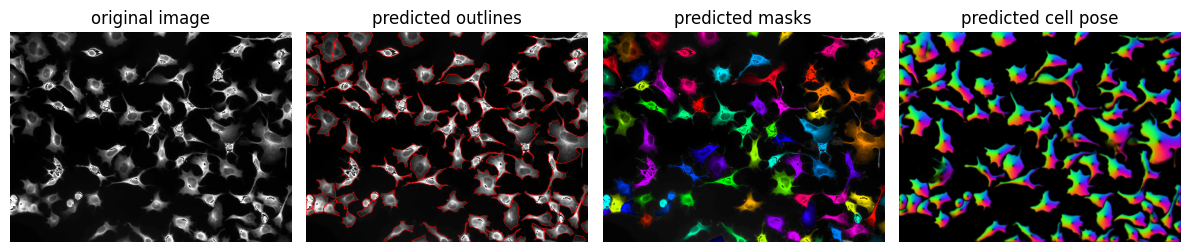

Code execution done


In [9]:
chatbot.chat('please write code to segment it')

In [ ]:
chatbot.chat('Please explain each plot in the figure')

In [12]:
!cp /Users/cat/Downloads/data/noise/img0.png ./

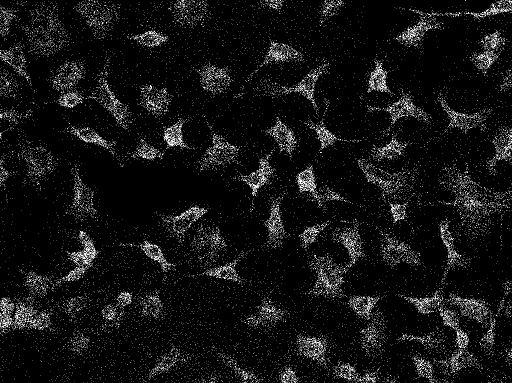

In [13]:
PIL.Image.open('./img0.png')

This image is very noisy and contains many small, densely packed objects.  Standard Cellpose segmentation might struggle.  The best approach is to use Cellpose's denoising capabilities before segmentation.  Here's the code:

```python
import numpy as np
from cellpose import models, plot, denoise
import matplotlib.pyplot as plt
from skimage.io import imread

# Load the image
img = imread('./img0.png')
if len(img.shape) == 3 and img.shape[-1]<=4:
    img = img[:,:,:3]
diameter = 30 #Keep diameter at default value.  Adjusting it won't help with noise.

# Instantiate the Cellpose denoising model
model = denoise.CellposeDenoiseModel(gpu=False, model_type="cyto3", restore_type="denoise_cyto3")

# Run cellpose to get masks and flows.  Denoising and segmentation happen together.
masks, flows, styles, imgs_dn = model.eval(img, diameter=diameter, channels=[0, 0])

# Display the segmentation results
fig = plt.figure(figsize=(12, 5))
plot.show_segmentation(fig, img, masks, flows[0], channels=[0, 0])
plt.tight_layout()
plt.show()
```

This code first uses the `CellposeDenoiseModel` to preprocess the image, reducing noise before segmentation.  The `diameter` parameter is kept at the default value because changing it won't effectively address the noise; the denoising model handles that.  The resulting segmentation should be more accurate than trying to segment the noisy image directly.


Execute code? (y/n):  y


Executing the generated code ...


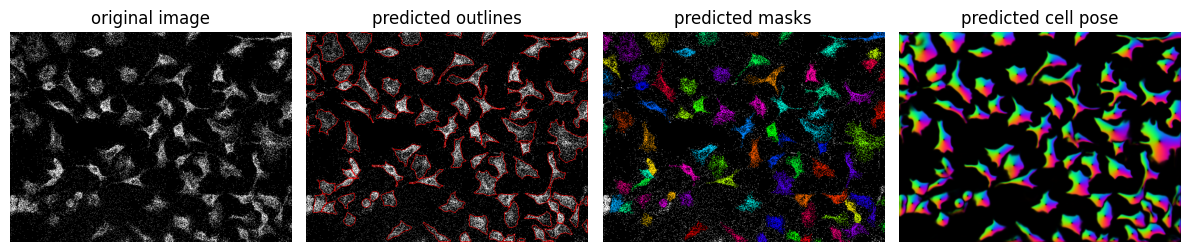

Code execution done


In [14]:
chatbot.chat('Here is another image. please segment it.', './img0.png')

```python
import numpy as np
from cellpose import models, plot, denoise
import matplotlib.pyplot as plt
from skimage.io import imread

# Load the image
img = imread('./img0.png')
if len(img.shape) == 3 and img.shape[-1]<=4:
    img = img[:,:,:3]
diameter = 30

# --- Cellpose Default Model ---
model_default = models.Cellpose(gpu=False, model_type='cyto')
masks_default, flows_default, styles_default, diams_default = model_default.eval(img, diameter=diameter, channels=[0, 0])

# --- Cellpose Denoise Model ---
model_denoise = denoise.CellposeDenoiseModel(gpu=False, model_type="cyto3", restore_type="denoise_cyto3")
masks_denoise, flows_denoise, styles_denoise, imgs_dn = model_denoise.eval(img, diameter=diameter, channels=[0, 0])


# --- Display Results ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Default Model Segmentation
axes[1].imshow(img, cmap='gray')
axes[1].imshow(masks_default, alpha=0.5, cmap='jet')
axes[1].set_title('Default Model Segmentation')
axes[1].axis('off')

# Denoise Model Segmentation
axes[2].imshow(img, cmap='gray')
axes[2].imshow(masks_denoise, alpha=0.5, cmap='jet')
axes[2].set_title('Denoise Model Segmentation')
axes[2].axis('off')

plt.tight_layout()
plt.show()

```

This code performs segmentation using both the standard Cellpose model and the denoising model, then displays the original image and the segmentation results side-by-side for comparison.  You can visually assess the differences in segmentation quality, particularly regarding noise handling and the accuracy of cell boundary detection. Remember that the effectiveness of the denoising model depends heavily on the nature of the noise in your image.


Execute code? (y/n):  y


Executing the generated code ...


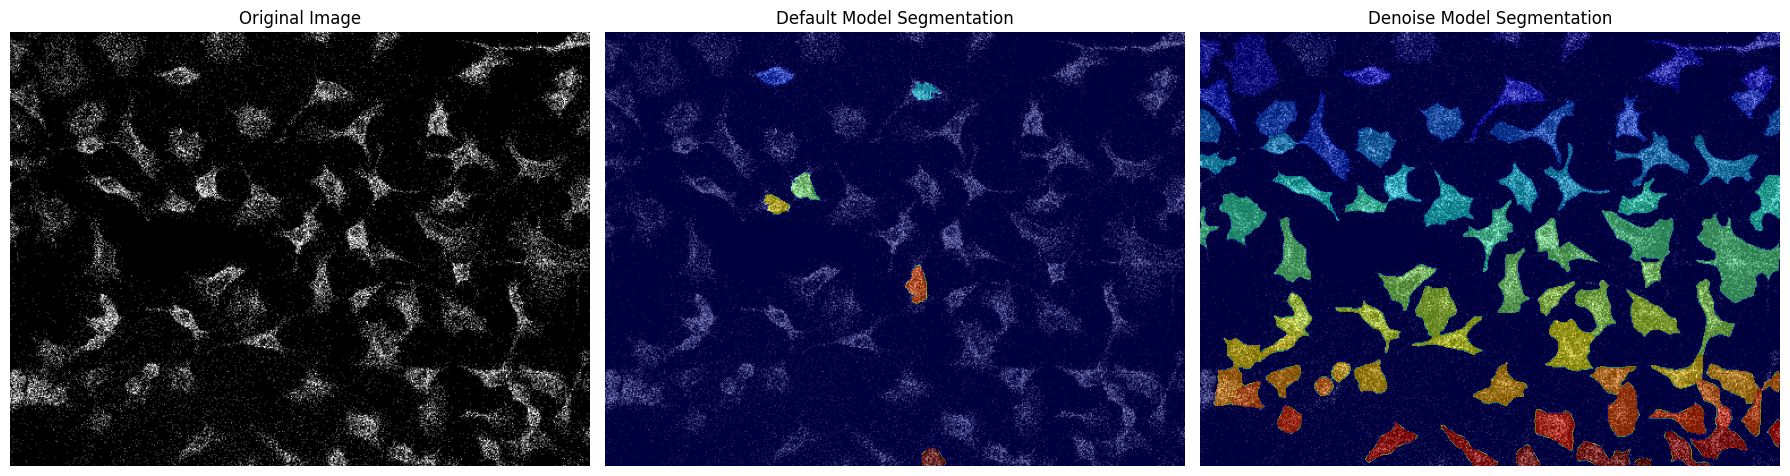

Code execution done


In [15]:
chatbot.chat('Please write code to compare the segmentation results of using the default cellpose model vs denoise model')

In [16]:
chatbot.chat('Please retrieve the source code of the eval function of the denoise model')

I cannot directly access and retrieve the source code of the `eval` function from the Cellpose repository in real-time.  My knowledge is based on a snapshot of the code at the time of my training.  The Cellpose codebase is constantly evolving, and accessing and displaying the current source code requires direct interaction with the repository (e.g., using `git` or browsing the GitHub repository).

However, I can give you guidance on how to find it yourself:

1. **Go to the Cellpose GitHub repository:**  Find the Cellpose project on GitHub.

2. **Locate the `denoise.py` file:** This file contains the `CellposeDenoiseModel` class.

3. **Find the `eval` method:** Inside the `CellposeDenoiseModel` class, you'll find the `eval` method.  It's a Python function, and you can view its source code directly within the file.

Remember that the code you find will be the current version in the repository, which might differ slightly from what I was trained on.  The core functionality should remain similar, but details might change over time.
